In [19]:
import pathlib
import urllib
import sys
import pandas as pd
import numpy as np
from scipy.stats import trim_mean, iqr, skew, kurtosis
import sklearn.decomposition as deco
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


# 1. Get the data

In [2]:
path = pathlib.Path('../data/adult.csv')
if path.exists():
    print('adult dataset found!')
else:
    sys.stdout.write('Downloading the adult dataset from the Internet...')
    ADULTURL = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    urllib.request.urlretrieve(ADULTURL, path.absolute())
    sys.stdout.write('Done!')

adult dataset found!


# 2. Understand the data in context


In [3]:
# Load the adult dataset into a Pandas dataframe
adult_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
adult = pd.read_csv(path.absolute(),names=adult_columns)

# 3. Understand the data
### 3.1 Describe the meansing and type for each attribute
 - **age**: numeric, continuous. 
 - **workclass**: categorical, discrete.
 - **fnlwgt**: numeric, continuous
 - **education**: ordinal, discrete
 - **education-num**: numeric, continuous
 - **marital-status**: categorical, discrete
 - **occupation**: categorical, discrete
 - **relationship**: categorical, discrete
 - **race**: categorical, discrete
 - **sex**: categorical, binary
 - **capital-gain**: numeric, continuous
 - **capital-loss**: numeric, continuous
 - **hours-per-week**: numeric, continuous
 - **native-country**: categorical, discrete
 - **>50k**: categorical, binary

*3.1 subsection: explanation for non-self-explanatory attributes*
 - **fnlwgt**: represents final weight. according to [2], it's the number of units that this record could represent in the 
 target population. In [1], the author explained that the final weight is controlled by three factors: a single cell estimatation
 of the population 16+ for each state; controls for Hispanic Origin by age and sex; controls by race, age and sex.
 - **education_num**: represents the number of years of education in total.[2]
 - **relationship**: represents the individual's role in it's family.[2]
 - **capital_gain** and **capital_loss**: represents the income and loss from non-salary ways, e.g. investment.[2]
 - **education**: due to lack of domain knowledge in U.S. education system, we decided to refer to [3].
 In which they order the education level in the following manner:  
 Preschool < 1st-4th < 5th-6th < 7th-8th < 9th < 10th < 11th < 12th < HS-grad < Prof-school < Assoc-acdm < Assoc-voc < Some-college < Bachelors < Masters < Doctorate.  
 [3] further merges  "Preschool", "1st-4th", "5th-6th", "7th-8th", "9th", "10th", "11th" and "12th" groups to "dropout" group,
 "Assoc-acdm" and "Assoc-voc" groups to "Associates" group,“HS-grad” and “Some-college” groups to “HS-Graduate” group.  
 For us, we would adopt this strategy, merging Prof-school into HS-Graduate group, and instead of arranging the education
 level like shown above, we have the following order:  
 dropout < hs-graduate < associates < bachelor < master < doctorate.
 
### 3.2 Verify data quality
#### 3.2.1 duplication

In [4]:
# Check duplication and drop duplication via pandas built in function
check_duplication = adult.duplicated()
duplicated = adult[check_duplication]
print("There are "+str(len(duplicated.index))+" duplicated data entries found.(One copy of the data entry will be kept in the dataset)")
adult = adult.drop_duplicates()
print("After drop duplicate, there are "+str(len(adult.index))+ " data entries remains.")
adult = adult.reset_index(drop=True)

There are 24 duplicated data entries found.(One copy of the data entry will be kept in the dataset)
After drop duplicate, there are 32537 data entries remains.


#### 3.2.2 missing values

In [5]:
# drop the indexes for which column has value '?'
unknown_row =[]

for i in range(len(adult.index)):
    if ('?' in adult.iloc[i]['workclass']) or ('?' in adult.iloc[i]['occupation']) or ('?' in adult.iloc[i]['native-country']):
        unknown_row.append(i)
adult = adult.drop(index = unknown_row)
adult = adult.reset_index(drop=True)
print("After drop the missing values, there are "+str(len(adult.index))+ " data entries remains.")

After drop the missing values, there are 30139 data entries remains.


#### 3.2.3 finding outliers

To find outlier, we only focus on numeric values
As we can see in the following, the calculated lower bound and upper bound for both capital_gain and capital loss is both 0. In 3.3 section we will see that the median for these two value are 0 either. Which means in this dataset most of the people
doesn't do investment and thus investment does not incur gain or loss to their income. So for this two attribute we just
don't do anything to the outliers

In [6]:
# we calculate interquantile range add use it as our guide line as detecting outlier

adult_numrics = adult.select_dtypes(include=['int64'])
Q1 = adult_numrics.quantile(0.25)
Q3 = adult_numrics.quantile(0.75)
iqr = Q3-Q1
# print(iqr)
# print(adult_numrics['capital-gain'])
lower_bound = Q1 - 1.5 * iqr
upper_bound = Q3 + 1.5 * iqr
print("By calculating interquantile range, we can get the expected lower/upper bound for each numeric value")
adult_numrics = adult_numrics.drop(['capital-gain','capital-loss'],axis='columns')
lower_bound.drop(['capital-gain','capital-loss'],inplace=True)
upper_bound.drop(['capital-gain','capital-loss'],inplace=True)
print("As explained before we drop the catipal-gain and capital-loss condition, and thus we have")
outliers = adult_numrics[((adult_numrics<lower_bound) | (adult_numrics>upper_bound)).any(axis=1)]
print("lower bound as:")
print(lower_bound)
print("and upper bound as:")
print(upper_bound)
print("After reviewing this calculated lower and upper bound, we decided to change some of the value. Since the result")
print("value would be an outlier according to the interquantile range, but still a reasonable value in reality")
print("The lower bound of hours-per-week is set to 20, which is the expected value for a part-time job")
print("The upper bound of age is set to 85, which is longer than the life expectancy in U.S., and around the value of ")
print("life expectancy in Canada")
print("The upper bound of hours-per-week is set to 72, which is calculated according to the \'famous\' 9-9-6 working load")
print("in China.")
print("The upper bound of education-num is set to 26, which is a little bit longer than the expected year of education of")
print("a Ph.D., which is 6 years for elementary, 6 years for middle and high school, 4 year undergraduate, 2 year master")
print("and 5 year Ph.D. studentship, add up to 23 years.")

lower_bound['hours-per-week'] = 20
upper_bound['age']=85
upper_bound['hours-per-week']=72
upper_bound['education-num'] = 26
outliers = adult_numrics[((adult_numrics<lower_bound) | (adult_numrics>upper_bound)).any(axis=1)]
print("After applying such filter, we found %d outliers in the dataset, which is a pretty large portion of the dataset"%len(outliers.index))
adult_inliers = adult.drop(outliers.index)
print("Consider the number of the outliers is quite big, we will just keep them inside the dataset and have a closer")
print("look in section 4 Exceptional Work")


By calculating interquantile range, we can get the expected lower/upper bound for each numeric value
As explained before we drop the catipal-gain and capital-loss condition, and thus we have
lower bound as:
age                  -0.5
fnlwgt           -62338.0
education-num         3.0
hours-per-week       32.5
dtype: float64
and upper bound as:
age                   75.5
fnlwgt            417570.0
education-num         19.0
hours-per-week        52.5
dtype: float64
After reviewing this calculated lower and upper bound, we decided to change some of the value. Since the result
value would be an outlier according to the interquantile range, but still a reasonable value in reality
The lower bound of hours-per-week is set to 20, which is the expected value for a part-time job
The upper bound of age is set to 85, which is longer than the life expectancy in U.S., and around the value of 
life expectancy in Canada
The upper bound of hours-per-week is set to 72, which is calculated according to 

### 3.2 Provide appropriate basic statistics
#### 3.2.1 Statistics about Numeric values

In [7]:
# select all columns with numeric values
adult_numeric = adult.select_dtypes(include=np.number)


In [8]:
cnames = ['mean', 'median', 'mode', 'trimmed mean (p=20%)', 'min', 'max', 'range', 'std']
adult_numeric.agg(lambda x: pd.Series([np.mean(x), np.median(x),x.mode()[0], trim_mean(x, 0.2),x.min(),x.max(),x.max()-x.min(),x.std()], index=cnames))

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
mean,38.441720,1.897950e+05,10.122532,1092.841202,88.439928,40.934703
median,37.000000,1.784170e+05,10.000000,0.000000,0.000000,40.000000
mode,36.000000,2.034880e+05,9.000000,0.000000,0.000000,40.000000
trimmed mean (p=20%),37.364999,1.775251e+05,10.025104,0.000000,0.000000,40.860879
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000
range,73.000000,1.470936e+06,15.000000,99999.000000,4356.000000,98.000000
std,13.131426,1.056586e+05,2.548738,7409.110596,404.445239,11.978753


In [9]:
"""
Numericalize the categorical columns
"""
adult_orginal=adult[:].copy()
# mapping dictioniary for education row, we take education as a ordinal attribute, as was explained earlier
education_mapping_dict = {' Preschool':1, ' 1st-4th':1, ' 5th-6th':1, ' 7th-8th':1, ' 9th':1, ' 10th':1, ' 11th':1, ' 12th':1,
                          ' HS-grad':2, ' Prof-school':2, ' Some-college':2,
                          ' Assoc-voc':3, ' Assoc-acdm':3,
                          ' Bachelors':4,
                          ' Masters':5,
                          ' Doctorate':6}
categorical_list=['workclass','marital-status','occupation','relationship','race','sex','native-country']
def categorical_is_converted(input_dtype):
    """
    check if the target categorical value is converted to some integer value
    :param input_dtype: the datatype of the input column
    :return: True if the dtype is some kind of integer, False otherwise
    """
    return input_dtype in [np.int, np.int64, np.int32, np.long]
def one_hot_batch(df, attribute_list,prefix_list=None):
    """
    :param attribute_list: list of attributes that waiting to be one hotted 
    :param prefix_list: list of prefix for the attribute after one-hot representation, if not set, just use the attribute name
    :return: False if unexpected input found, otherwise return the result dataframe
    """
    if prefix_list is None:
        prefix_list = attribute_list
    if not len(attribute_list) == len(prefix_list):
        return False
    for i in range(len(attribute_list)):
        if not categorical_is_converted(df[attribute_list[i]].dtype):
            dummies = pd.get_dummies(df[attribute_list[i]], prefix=prefix_list[i])
            df = df.drop(columns=[attribute_list[i]])
            df = pd.concat([df,dummies], axis=1)
    return df
# map education to integers
if not categorical_is_converted(adult['education'].dtype):
    adult = adult.replace({'education': education_mapping_dict})
# convert all non-ordinal categorical attribute using one-hot representation
adult = one_hot_batch(adult, categorical_list)
# map the prediction target: the ultimate income rank into integer. Since it's binary, we don't use one hot representation
if not categorical_is_converted(adult['income'].dtype):
    for i in range(len(adult.index)):
        if '>50K' in adult.iloc[i]['income']:
            adult.iloc[i, adult.columns.get_loc('income')] = 1
        else:
            adult.iloc[i,adult.columns.get_loc('income')] = 0


### 3.4 Visualize the most important or interesting attributes
In this section we visualize the attributes that we think is very important

Work class has always been an important feature that might influence the income, since in most cases people rely on their
salary. 
#### 3.4.1 workclass counts

 
Plot the pie chart of workclasses. The dominate workclass is private which consists 73.9% of the people.

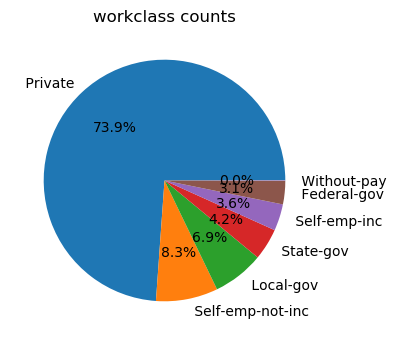

In [10]:
X = adult_orginal['workclass'].value_counts().values
L=adult_orginal['workclass'].value_counts().index
plt.figure(figsize=(6,4), dpi=100)
plt.pie(X, labels=L, autopct = '%1.1f%%')
plt.title('workclass counts')
plt.show()

#### 3.4.2 boxplot of ages in different workclasses

We can see that the range, quatiles and median of age differs from workclass to workclass. People in their younger age may be more willing to work without pay.

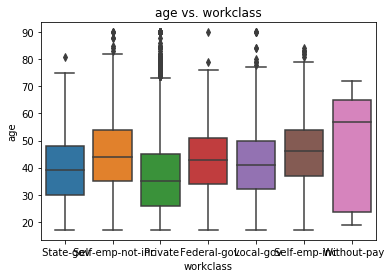

In [11]:
ax = sns.boxplot( x=adult_orginal["workclass"], y=adult_orginal["age"] ).set_title('age vs. workclass')
plt.show()

#### 3.4.3 histogram for capital gains and capital loss
Capital income is another important feature when the context is about income, add according to my personal real world observation,
rich people are more interested in asset investment, while normal individuals may tend to only rely on their salary. This
is what every 'How to become a millionaire in 30 days' tell you. Thus we think study the distribution of it might be an 
interesting topic.

Plot the histogram of the capital gain and capital loss. We can see from the histogram that almost all people’s capital gain and loss are 0, which means there’re no gains or losses that an individual experiences on the sale of a capital asset.

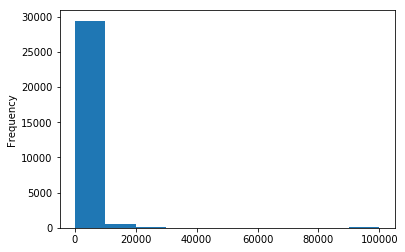

In [12]:
gain_counts = adult_orginal['capital-gain']
gain_counts.plot.hist()

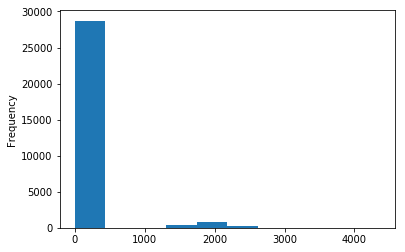

In [13]:
gain_counts = adult_orginal['capital-loss']
gain_counts.plot.hist()

#### 3.4.4 Validfy the importance of the feature selected above using feature importance

In [22]:
forest = ExtraTreesClassifier(n_estimators=200)
features = adult.drop(columns=['income'])
forest.fit(X=features,y=adult['income'])
importance = forest.feature_importances_

In [28]:
# pair the importance with their attribute name
dict_importance = {}
for i in range(len(list(features.columns))):
    dict_importance[list(features.columns)[i]]=importance[i]
# group them together
grouped_importance = {}
categorical_list
unexpended_attributes = list(adult_orginal.columns)
unexpended_attributes.remove('income')
expanded_attributes = list(dict_importance.keys())
for attribute_name in unexpended_attributes:
    if attribute_name not in categorical_list:
        grouped_importance[attribute_name] = dict_importance[attribute_name]
    else:
        sum=0.0
        for key in expanded_attributes:
            if attribute_name in key:
                sum += dict_importance[key]
        grouped_importance[attribute_name] = sum
print(grouped_importance)

{'age': 0.15167018261735446, 'workclass': 0.03648626712888228, 'fnlwgt': 0.1697836118977288, 'education': 0.05108068210714614, 'education-num': 0.06416410270917254, 'marital-status': 0.10184838006623077, 'occupation': 0.09218237234871789, 'relationship': 0.0904801279503974, 'race': 0.015251153574509329, 'sex': 0.019584316142276507, 'capital-gain': 0.06774666146113995, 'capital-loss': 0.0226065742966112, 'hours-per-week': 0.0929776848166387, 'native-country': 0.02413788288319396}


### 3.5 Explore the relationships among the attributtes
#### 3.5.1 correlation matrices

In [14]:
#correlation matrices
adult_orginal.corr()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076279,0.043203,0.080162,0.060141,0.101348
fnlwgt,-0.076279,1.000000,-0.045199,0.000420,-0.009755,-0.023033
education-num,0.043203,-0.045199,1.000000,0.124455,0.079613,0.152842
capital-gain,0.080162,0.000420,0.124455,1.000000,-0.032255,0.080429
capital-loss,0.060141,-0.009755,0.079613,-0.032255,1.000000,0.052380
hours-per-week,0.101348,-0.023033,0.152842,0.080429,0.052380,1.000000


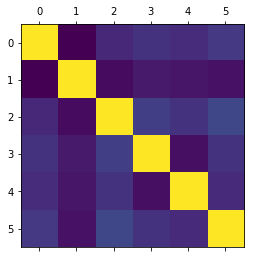

In [15]:
plt.matshow(adult_orginal.corr())

#### 3.5.2 cross tabulations

In [16]:
twowayct = pd.crosstab(index=adult_orginal['relationship'], columns=adult_orginal['income'], margins=False)
twowayct.columns=['lte50K','gt50K']
twowayct

,lte50K,gt50K
relationship,,
Husband,6780,5677
Not-in-family,6891,823
Other-relative,854,35
Own-child,4398,64
Unmarried,2998,213
Wife,712,694


### 3.6 relationships between class attribute and the other attribute
#### 3.6.1 workclass group-wise statistics

In [17]:
adult_1 = adult_orginal.drop(columns=['fnlwgt'])
combined_class=adult_1.groupby('workclass').agg(['mean', 'median', 'std']).T
adult1=None
combined_class

workclass               Federal-gov    Local-gov      Private   Self-emp-inc  \
age            mean       42.577943    41.743106    36.798374      46.027933   
               median     43.000000    41.000000    35.000000      46.000000   
               std        11.532840    12.267402    12.837864      12.689685   
education-num  mean       10.948038    11.036768     9.872485      11.167598   
               median     10.000000    10.000000    10.000000      10.000000   
               std         2.100565     2.545539     2.482323       2.544997   
capital-gain   mean      832.321315   829.230285   880.727632    4810.746741   
               median      0.000000     0.000000     0.000000       0.000000   
               std      4111.473884  5375.040712  6341.187485   17828.904145   
capital-loss   mean      111.731707   110.323174    79.708184     153.504655   
               median      0.000000     0.000000     0.000000       0.000000   
               std       451.148107   440.372500   383.354450     546.910433   
hours-per-week mean       41.279958    41.002419    40.254851      48.802607   
               median     40.000000    40.000000    40.000000      50.000000   
               std         8.720239    10.760325    11.262432      13.777156   

workclass               Self-emp-not-inc    State-gov   Without-pay  
age            mean            45.010008    39.362002     47.785714  
               median          44.000000    39.000000     57.000000  
               std             13.366507    12.386871     21.075610  
education-num  mean            10.211369    11.349492      9.071429  
               median          10.000000    10.000000      9.000000  
               std              2.757187     2.530994      1.685426  
capital-gain   mean          1913.900320   684.306489    487.857143  
               median           0.000000     0.000000      0.000000  
               std          11076.735577  3771.592651   1300.780467  
capital-loss   mean           115.618495    81.147772      0.000000  
               median           0.000000     0.000000      0.000000  
               std            465.828429   388.739091      0.000000  
hours-per-week mean            44.433947    39.053948     32.714286  
               median          40.000000    40.000000     27.500000  
               std             16.685741    11.669861     17.357900

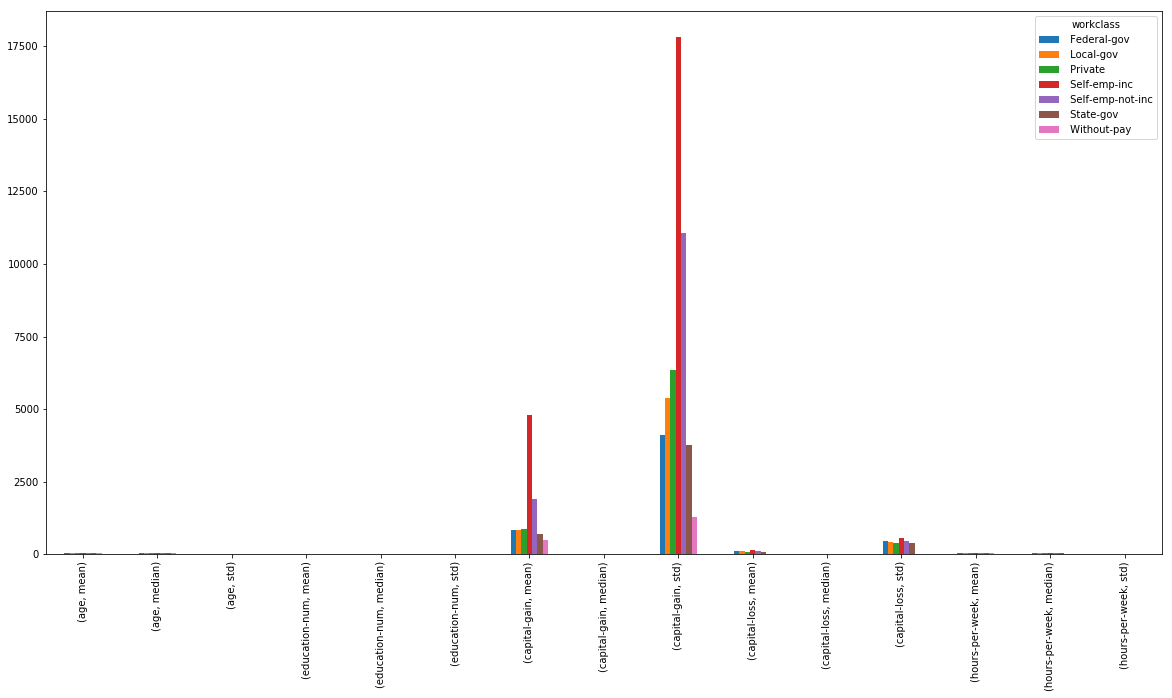

In [18]:
plt.rcParams['figure.figsize'] = (20,10)
combined_class.plot.bar()


# 4 Exceptional work
In section 3.2.3 we used interquantile range to find the outlier, and we found around 4000 samples are tagged as outlier,
which is quite a large portion. So, in this section, we will study these outliers and evaluate how they influence our viewport
of this dataset. Our evaluation of outlier finding algorithm includes the following two aspects:

 - We employ some dimensional reduction algorithm that reduces the entire dataset to 2 and 3 dimension, we then treat 
 outliers and commoners as different classes and render them in different colors, and thus study their behavior.
 - We employ classifiers trained on both full training set and the training set without outlier, and we observed a accuracy
 loss using 5-fold validation, we thus conclude that the out-lier detection with interquantile range does not fit this dataset 
 
### 4.1 PCA and visualization
We applied principle component analysis to transform the entire dataset into 2d and 3d dimension, then we plot them with
scatter in both dimension. The outliers are in red color and the commoners are in blue color. In the 2d plot we can see 
that the outliers are basically overlaps with the commoners, and for the 3d plot we found out that the commoners and outliers
can be distinguishable; however, the distance between the outliers and the nearest commoners are not huge, and far less then
the furthest distance between different cluster of commoners, we therefore infer that the outliers are still valuable data
entries in our dataset and does not recommand to just remove this; we also infer that the outliers are introduced just 
because the nature of the data is not evenly distributed instead of an error. 

True
[[-1.12278991e+05  1.08464409e+03 -9.07193328e+01]
 [ 2.58509450e+04 -1.09345043e+03 -8.94071730e+01]
 [ 4.49259448e+04 -1.09401424e+03 -8.86662167e+01]
 ...
 [ 3.24920945e+05 -1.10232396e+03 -7.82713806e+01]
 [ 1.85294516e+03 -1.09274335e+03 -9.03658360e+01]
 [-7.36570548e+04 -1.09050291e+03 -9.31762692e+01]]


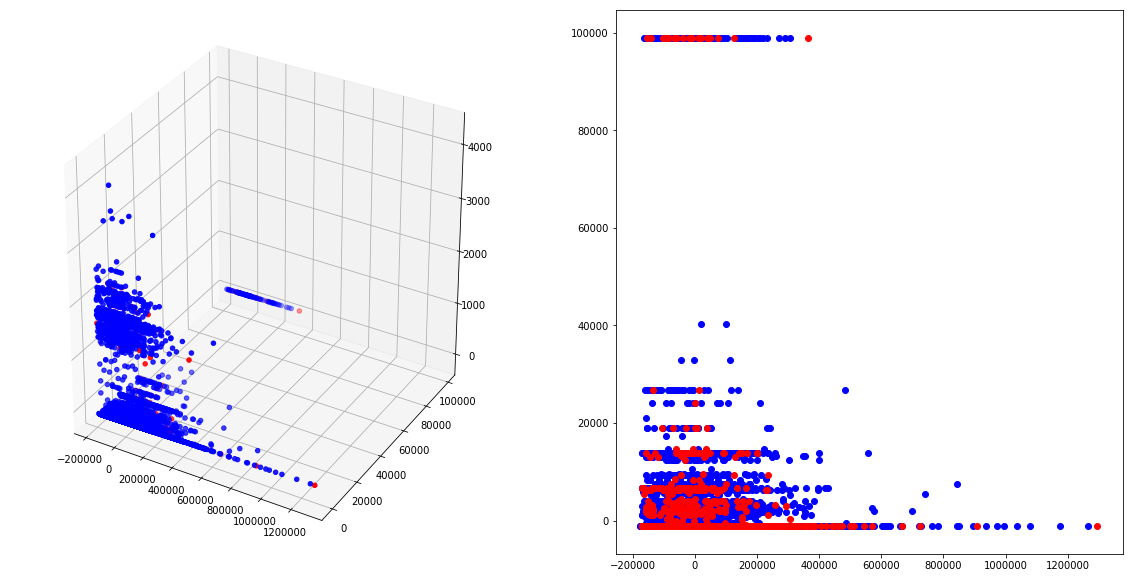

In [23]:
iqr_outliers = adult_numrics[((adult_numrics<lower_bound) | (adult_numrics>upper_bound)).any(axis=1)]
iqr_outliers.sample(5)
iqr_inliers = adult.drop(outliers.index)
iqr_outliers = adult.loc[iqr_outliers.index]
iqr_outliers.sample(5)
iqr_outliers.loc[:,'out_lier'] = 1
iqr_inliers.loc[:,'out_lier'] = 0
total = pd.concat([iqr_inliers,iqr_outliers])


print('out_lier' in iqr_outliers.columns)
is_outlier = total['out_lier']
pca = deco.PCA(n_components=3)
attributes = total.drop(columns=['out_lier']).values
reduced = pca.fit_transform(attributes)
print(reduced)
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')

x0=[];y0=[];z0=[];x1=[];y1=[];z1=[]
for i in range(len(reduced)):
    if is_outlier[i] == 0:
        x0.append(reduced[i][0])
        y0.append(reduced[i][1])
        z0.append(reduced[i][2])
    else:
        x1.append(reduced[i][0])
        y1.append(reduced[i][1])
        z1.append(reduced[i][2])
ax.scatter(x0,y0,z0,c='b')
ax.scatter(x1,y1,z1,c='r')

pca2 = deco.PCA(n_components=2)
reduced = pca2.fit_transform(attributes)
bx = fig.add_subplot(122)
x0=[];y0=[];x1=[];y1=[]
for i in range(len(reduced)):
    if is_outlier[i] == 0:
        x0.append(reduced[i][0])
        y0.append(reduced[i][1])
    else:
        x1.append(reduced[i][0])
        y1.append(reduced[i][1])
bx.scatter(x0,y0,c='b')
bx.scatter(x1,y1,c='r')
plt.show()

### 4.2 Evaluation of outlier detection algorithm using performance of classifer

The intuition of collecting this dataset is to predict if a input person bolongs to high income group or not (>50K). So 
we employed two classification algorithm, trained and tested them using 5 fold validation. Both of the algorithm are trained
on both the full training data and the training data without outliers, and thus by comparing their performance we can evaluate
how outliers influences the classification process, and further evaluate the outlier detection algorithm.  
The two algorithm include Support Vector Machine (LinearSVC) which in theory should be easily influenced by outliers and 
Random Forest (RandomForestClassfier) which has some natural immunity to outliers.

After a 5 fold validation, we found out that for random forest classifier, it looks like that including and excluding 
outliers only pose minior influence to the performance. However, for support vector machine classifier, the performance
might be impacted both positively and negatively, and among multiple trials the performance is unreliable. Consider that sklearn prompts warning during the
training of SVC, we conclude that such performance change might be due to the non-linearty of the nature of the data, and
thus does not support the point that the outlier detection algorithm is effective.

In [29]:
print(list(iqr_outliers.columns))
iqr_outliers
iqr_inliers
shuffeled_out=iqr_outliers.sample(frac=1)
out_lier_list=np.array_split(shuffeled_out,5)
shuffeled_in=iqr_inliers.sample(frac=1)
in_lier_list=np.array_split(shuffeled_in,5)

def get_acc(classifier_name, train_x, train_y, test_x, test_y):
    """
    calculate the accuracy trained with the given training data and return the accuracy evaluated using the given testing
    data
    :param classifier_name: a string indicating the target classifier algorithm, should be either 'SVM' or 'RF' 
    :param train_x: attributes of the training set
    :param train_y: label of the training set
    :param test_x: attributes of the testing set
    :param test_y: label of the testing set
    :return: the accuracy evaluated on the testing set
    """
    if classifier_name == 'SVM':
        classifier_ = LinearSVC(max_iter=5000)
    else:
        classifier_ = RandomForestClassifier(n_estimators=50, max_depth=5)
    classifier_.fit(train_x, train_y)
    return classifier_.score(test_x, test_y)
svm_all = []
svm_inlier = []
rf_all = []
rf_inlier = []
for i in range(5):
    test = [out_lier_list[i],in_lier_list[i]]
    test_ = pd.concat(test)
    train = out_lier_list[0:i]+out_lier_list[i+1:5]+in_lier_list[0:i]+in_lier_list[i+1:5]
    train_ = pd.concat(train)
    train_inliers = train_.loc[train_['out_lier']==0]
    svm_all.append(get_acc('SVM',
                           train_x=train_.drop(columns=['out_lier','income']),
                           train_y=train_['income'],
                           test_x=test_.drop(columns=['out_lier','income']),
                           test_y=test_['income']
                           )
                   )
    svm_inlier.append(get_acc('SVM',
                           train_x=train_inliers.drop(columns=['out_lier','income']),
                           train_y=train_inliers['income'],
                           test_x=test_.drop(columns=['out_lier','income']),
                           test_y=test_['income']
                           )
                   )
    rf_all.append(get_acc('RF',
                           train_x=train_.drop(columns=['out_lier','income']),
                           train_y=train_['income'],
                           test_x=test_.drop(columns=['out_lier','income']),
                           test_y=test_['income']
                           )
                   )
    rf_inlier.append(get_acc('RF',
                           train_x=train_inliers.drop(columns=['out_lier','income']),
                           train_y=train_inliers['income'],
                           test_x=test_.drop(columns=['out_lier','income']),
                           test_y=test_['income']
                           )
                   )

['age', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'income', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct', 'occupation_ Other-service', 'occupation_ Priv-house-serv', 'occupation_ Prof-specialty', 'occupation_ Protective-serv', 'occupation_ Sales', 'occupation_ Tech-support', 'occupation_ Transport-moving', 'relationship_ Husband', 'relationship_ Not-in-family', 'relation

C:\Users\rolo_\venv\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rolo_\venv\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rolo_\venv\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rolo_\venv\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rolo_\venv\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Us

In [30]:
def mean(lst):
    return sum(lst)/float(len(lst))
print("svm with all training data average accuracy "+ str(mean(svm_all)))
print("svm with commoner training data average accuracy "+ str(mean(svm_inlier)))
print("RandomForest with all training data average accuracy "+ str(mean(rf_all)))
print("RandomForest with commoner training data average accuracy "+ str(mean(rf_inlier)))

svm with all training data average accuracy 0.6765689323943602
svm with commoner training data average accuracy 0.5952985619126671
RandomForest with all training data average accuracy 0.8360595193780167
RandomForest with commoner training data average accuracy 0.8334384563866493


# Reference
    [1] Kaggle adult census income dataset. Date accessed: Sept. 2019. url: https://www.kaggle.com/uciml/adult-census-income
    [2] Haojun Zhu, Predicting Earning Potential using the Adult Dataset. Dec. 2016. url: https://rstudio-pubs-static.s3.amazonaws.com/235617_51e06fa6c43b47d1b6daca2523b2f9e4.html
    [3] Bui Dinh Chien, Jean-Daniel Zucker, Complex Data Mining Project. Date accessed: Sept. 2019. url: https://sites.google.com/site/complexdataminingproject/.